In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
from numpy.polynomial.polynomial import Polynomial
import statsmodels.api as sm
from scipy import stats
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon
from statsmodels.tsa.stattools import grangercausalitytests
from prophet import Prophet

**Mercado Libre y Nintendo**


---





In [ ]:
# Obtener datos de acciones
df = yf.download(
    tickers=['MELI', 'NTDOY'],            # tickers: AAPL: Apple, TSLA: Tesla, etc.
    start='2020-01-01',        # Fecha de inicio
    end='2022-01-01',          # Fecha de fin
    interval='1d',             # Intervalo de tiempo (1 día)
    group_by=None,             # Agrupar por ticker
    auto_adjust=False,         # ajusta automáticamente los precios de cierre, apertura, máximo y mínimo para tener en cuenta los dividendos y divisiones de acciones.
    actions=False,             # Si se establece en True, incluye datos sobre acciones, como dividendos y divisiones.
    )

# Link para inspeccionar tickers: https://www.nasdaq.com/market-activity/stocks/screener

# Paso 1: Mover 'Date' del índice a columna regular
df = df.reset_index()

# Paso 2: Aplanar el MultiIndex de las columnas, manteniendo 'Open', 'High', etc.
df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df.columns.values]


# Paso 3:
#######################################################
## En caso de que no se requiera la hora
# Convertir la columna 'Date' a tipo datetime si no lo es ya
df['Date'] = pd.to_datetime(df['Date'])

df['Date'] = df['Date'].dt.date
##
#######################################################

# Paso 4: La fecha vuelve a ser un índice
df.set_index('Date', inplace=True)


df

[*********************100%***********************]  2 of 2 completed


,NTDOY_Open,NTDOY_High,NTDOY_Low,NTDOY_Close,NTDOY_Adj Close,NTDOY_Volume,MELI_Open,MELI_High,MELI_Low,MELI_Close,MELI_Adj Close,MELI_Volume
Date,,,,,,,,,,,,
2020-01-02,10.136,10.164,10.090,10.138,10.138,1180500,576.940002,615.840027,576.940002,610.190002,610.190002,589200
2020-01-03,9.946,10.100,9.946,10.050,10.050,506000,602.619995,609.840027,600.059998,607.799988,607.799988,320900
2020-01-06,9.880,9.936,9.824,9.910,9.910,1162500,601.039978,613.789978,601.000000,606.549988,606.549988,209700
2020-01-07,9.880,9.902,9.810,9.832,9.832,1096500,606.640015,627.969971,604.739990,625.000000,625.000000,480900
2020-01-08,9.820,9.950,9.780,9.922,9.922,2783000,625.000000,637.820007,624.549988,633.440002,633.440002,334600
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,12.000,12.274,12.000,12.260,12.260,2470500,1275.000000,1310.520020,1273.000000,1299.109985,1299.109985,485800
2021-12-28,11.942,12.050,11.934,11.954,11.954,1528000,1309.829956,1331.410034,1301.239990,1316.280029,1316.280029,407500
2021-12-29,11.814,12.000,11.814,11.898,11.898,798000,1309.969971,1330.000000,1305.449951,1323.560059,1323.560059,405700


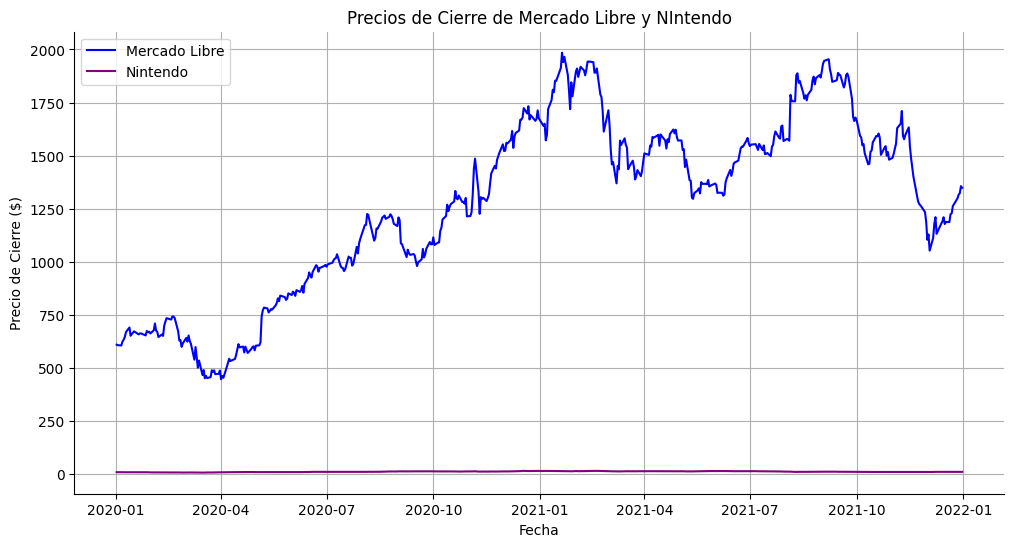

In [ ]:
# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['MELI_Close'], label='Mercado Libre', color='blue')
plt.plot(df['NTDOY_Close'], label='Nintendo', color='purple')
plt.title('Precios de Cierre de Mercado Libre y NIntendo')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**"Mercado Libre"**


---



**Medias Moviles**

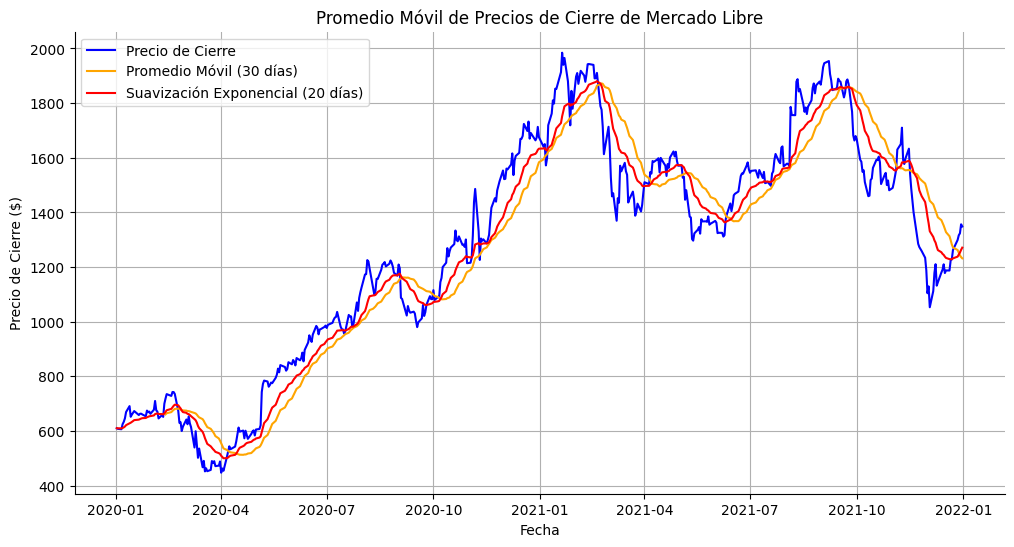

In [ ]:
# Promedio Móvil Simple
ventana_sma = 30
df['SMA'] = df['MELI_Close'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 20
df['SES'] = df['MELI_Close'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['MELI_Close'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='red')
plt.title('Promedio Móvil de Precios de Cierre de Mercado Libre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Lo que se puede analizar de esta gráfica es que ha tenido una tendencia positiva ya que entre el periodo del 2020 al 2022 ha subido su precio, tuvo un crecimiento rotundo por un factor externo (la pandemia) y logro estabilizarse


**Regresión Polinomial**



In [ ]:
# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['MELI_Close']

# Paso 3: Ajustar un modelo polinómico
grado = 7
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

**Gráfica de la Regresión Polinomial y sus Residuales**



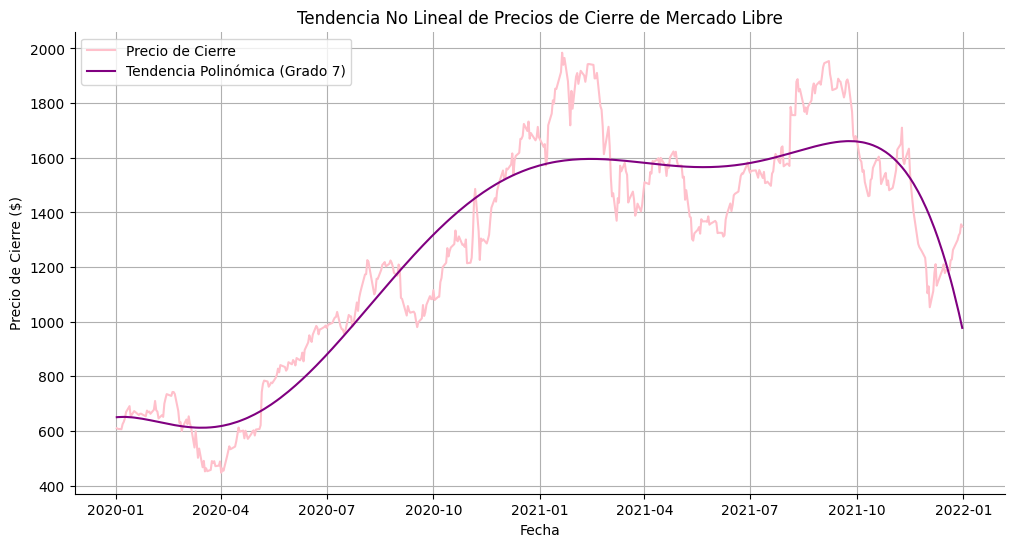

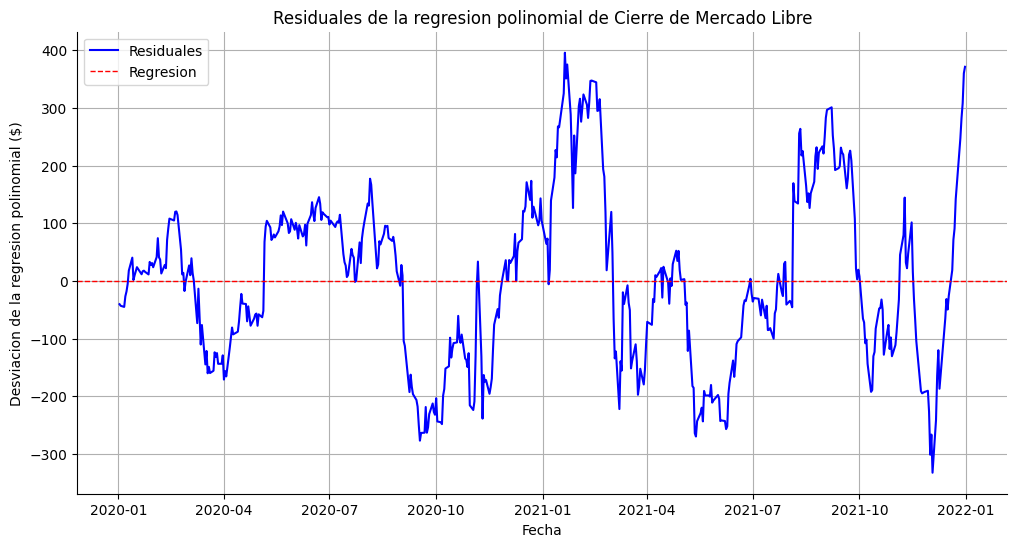

In [ ]:
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='pink'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de Mercado Libre') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de Mercado Libre')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Descomposición de la Serie de Tiempo y su Gráfica**

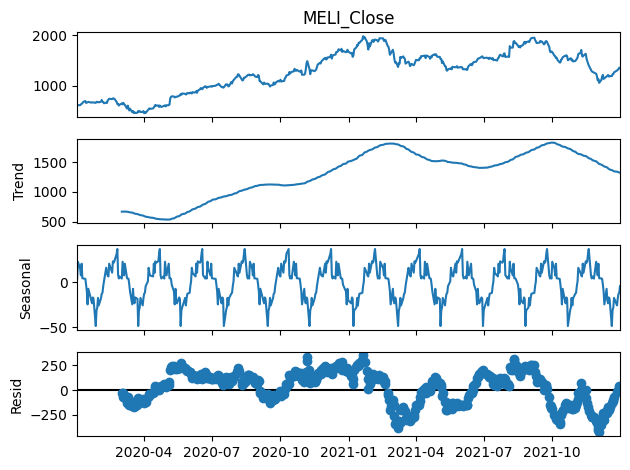

In [ ]:
# Descomponer la serie temporal
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(
    df['MELI_Close'],
    model='additive',
    period=40,
    extrapolate_trend=0,
    two_sided=False,
    )  # 252 días de negociación al año
fig = descomposicion.plot()
plt.show()

La tendencia va en subida y de cierta manera se mantiene estable, aunque por lo que se puede visualizar la estacionalidad esta marcada aunque con obvias subidas y bajadas, ademas el ruido que se encuentra no posee un patrón por lo que no es muy relevante

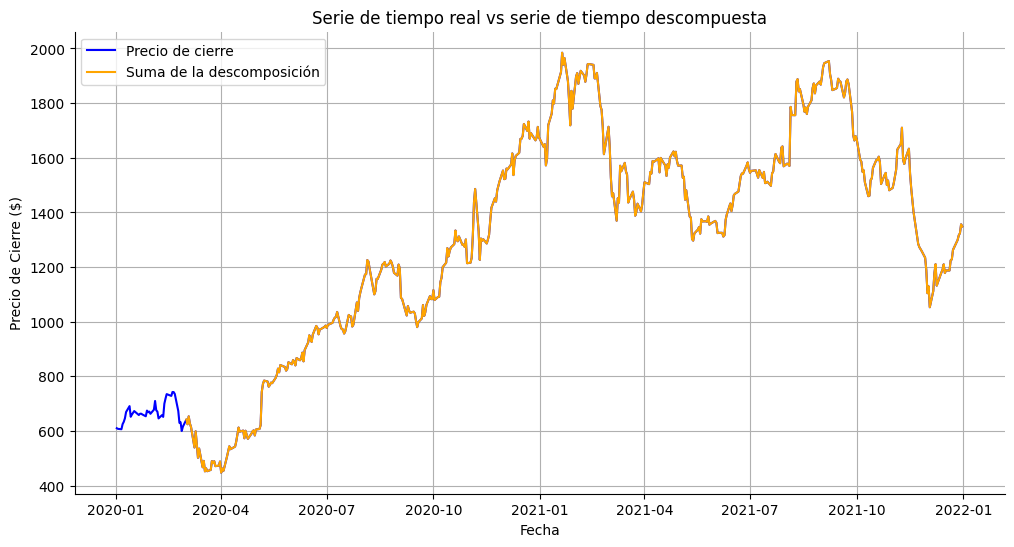

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['MELI_Close'], label='Precio de cierre', color='blue')
plt.plot(descomposicion.trend + descomposicion.seasonal + descomposicion.resid, label=f'Suma de la descomposición', color='orange')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

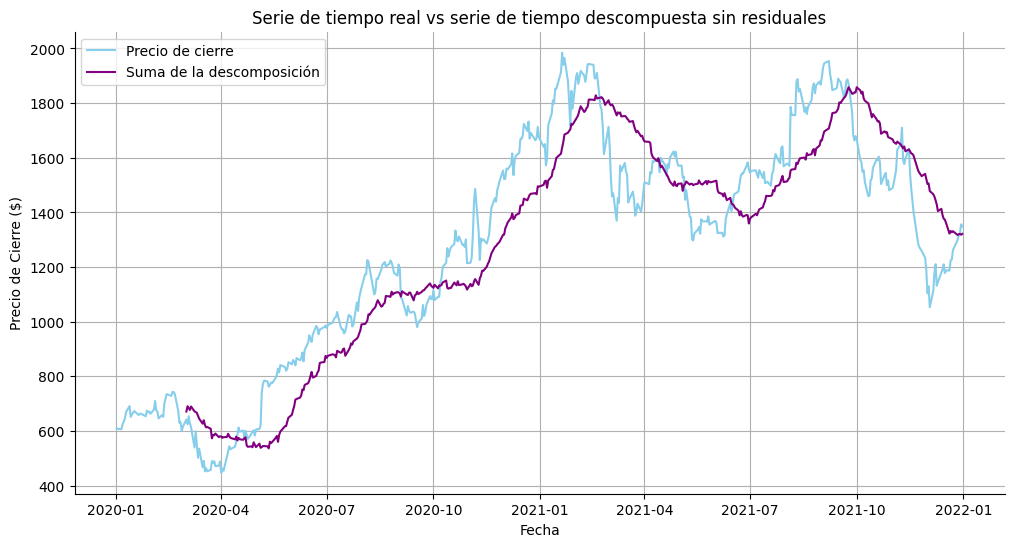

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['MELI_Close'], label='Precio de cierre', color='#87CEEB')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

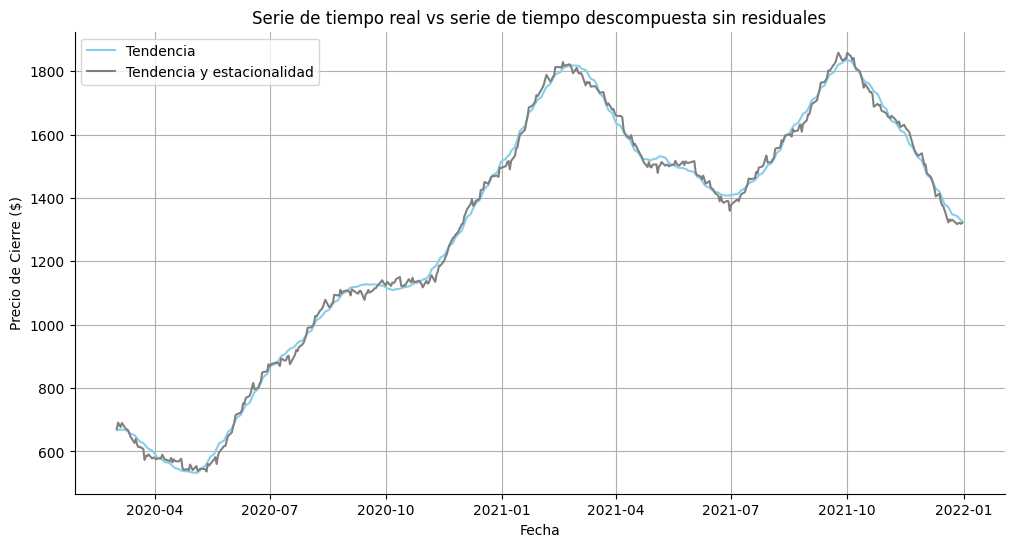

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(descomposicion.trend, label='Tendencia', color='#87CEEB')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Tendencia y estacionalidad', color='gray')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

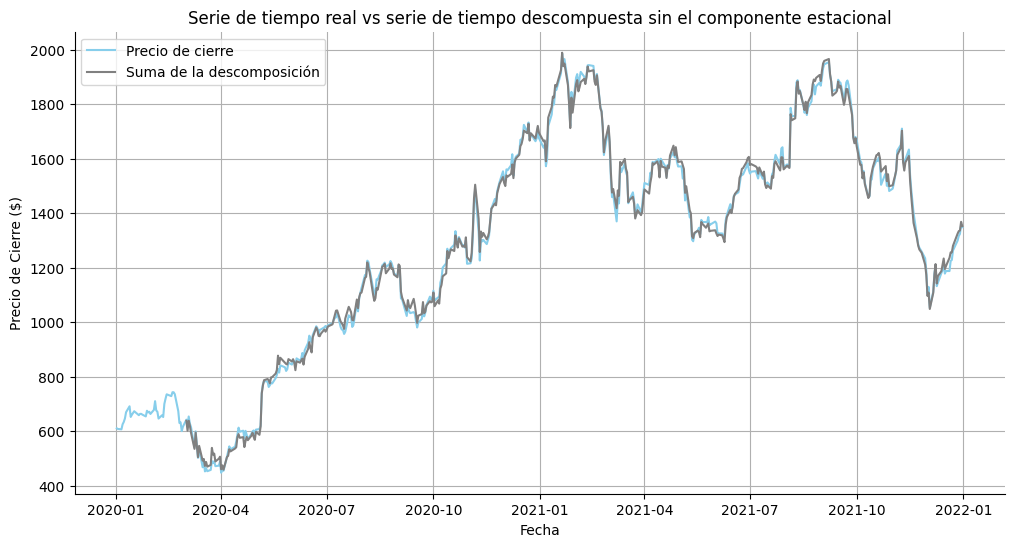

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['MELI_Close'], label='Precio de cierre', color='#87CEEB')
plt.plot(descomposicion.trend + descomposicion.resid, label=f'Suma de la descomposición', color='gray')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin el componente estacional')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

 **Realiza una prueba de hipótesis para comprobar que se haya capturado correctamente la estacionalidad. Y realiza otra prueba de hipótesis para comprobar si la estacionalidad es significativa**

In [ ]:
# Prueba t pareada para el efecto significativo de la estacionalidad

#Hipótesis nula (H₀): Ambas series son iguales.
#Hipótesis alternativa (H₁): Ambas series son diferentes


nivel_de_significancia = 0.05
tendencia = descomposicion.trend
tendencia_estacionalidad = descomposicion.seasonal + descomposicion.trend

# Eliminar valores NaN de ambas series
tendencia.dropna(inplace=True)
tendencia_estacionalidad.dropna(inplace=True)

# Realizar la prueba t pareada
t_stat, p_valor = ttest_rel(tendencia, tendencia_estacionalidad)

print("Estadístico t:", t_stat)
print("Valor p:", p_valor)
print("\n")

# Interpretación de los resultados
if p_valor < nivel_de_significancia:
    print("El valor p es menor que 0.05, por lo tanto, rechazamos la hipótesis nula.")
    print("Conclusión: La estacionalidad tiene un efecto significativo en la serie de tiempo.")
else:
    print("El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.")
    print("Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.")

Estadístico t: 0.5656217324056629
Valor p: 0.5719243598855287


El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.
Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.


In [ ]:
# Prueba Wilcoxon pareada para el efecto significativo de la estacionalidad

#Hipótesis nula (H₀): Ambas series son iguales.
#Hipótesis alternativa (H₁): Ambas series son diferentes

tendencia = descomposicion.trend
tendencia_estacionalidad = descomposicion.seasonal + descomposicion.trend

# Eliminar valores NaN de ambas series
tendencia.dropna(inplace=True)
tendencia_estacionalidad.dropna(inplace=True)

# Realizar la prueba de Wilcoxon
w_stat, p_valor = wilcoxon(tendencia, tendencia_estacionalidad)

print("Estadístico de Wilcoxon:", w_stat)
print("Valor p:", p_valor)
print("\n")

# Interpretación de los resultados
if p_valor < 0.05:
    print("El valor p es menor que 0.05, por lo tanto, rechazamos la hipótesis nula.")
    print("Conclusión: La estacionalidad tiene un efecto significativo en la serie de tiempo.")
else:
    print("El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.")
    print("Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.")

Estadístico de Wilcoxon: 53391.0
Valor p: 0.7874949660758763


El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.
Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.


**Utilizando los componentes de la descomposición, realiza un gráfico que contenga la serie de tiempo real, la tendencia, la serie sin estacionalidad, y la serie sin ruido.**

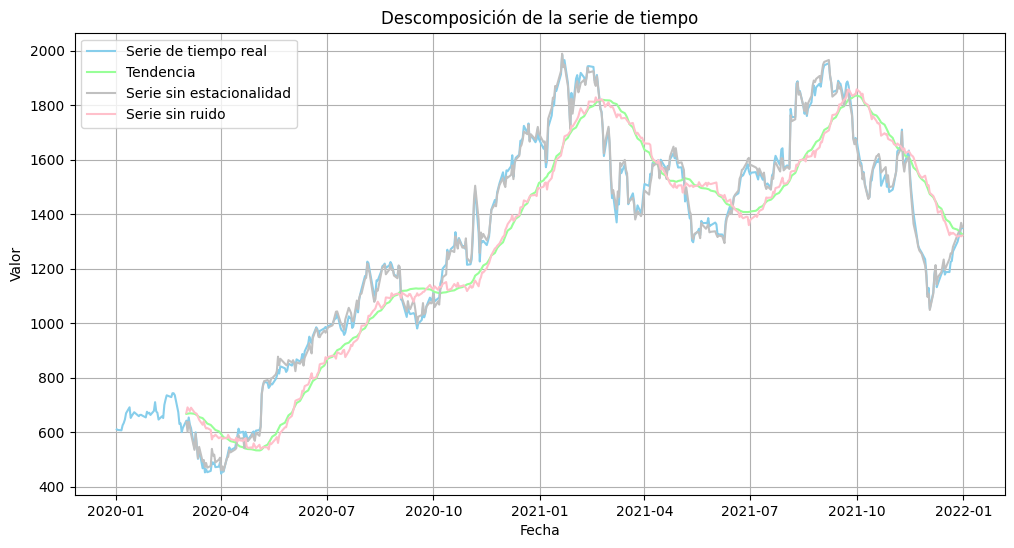

In [ ]:
# Define los datos para el gráfico
serie_real = df['MELI_Close']  # Serie de tiempo real
tendencia = descomposicion.trend  # Tendencia
sin_estacionalidad = descomposicion.trend + descomposicion.resid  # Serie sin estacionalidad
sin_ruido = descomposicion.trend + descomposicion.seasonal  # Serie sin ruido

# Crea el gráfico
plt.figure(figsize=(12, 6))
plt.plot(serie_real, label='Serie de tiempo real', color='#87CEEB')
plt.plot(tendencia, label='Tendencia', color='#98FF98')
plt.plot(sin_estacionalidad, label='Serie sin estacionalidad', color='#C0C0C0')
plt.plot(sin_ruido, label='Serie sin ruido', color='pink')

# Personaliza el gráfico
plt.title('Descomposición de la serie de tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)

# Muestra el gráfico
plt.show()

**Nintendo**

---



**Medias Moviles**

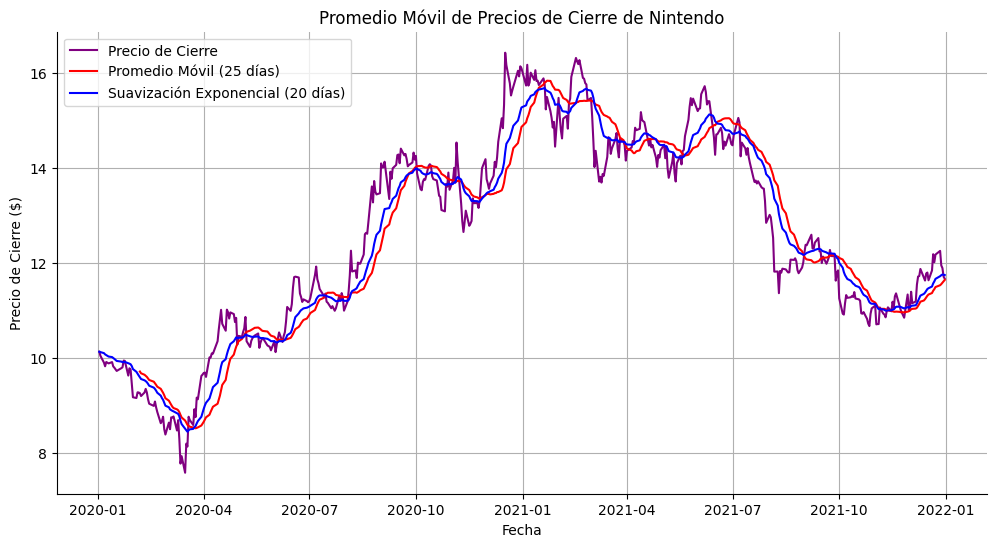

In [ ]:
# Promedio Móvil Simple
ventana_sma = 25
df['SMA'] = df['NTDOY_Close'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 20
df['SES'] = df['NTDOY_Close'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['NTDOY_Close'], label='Precio de Cierre', color='purple')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='red')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='blue')
plt.title('Promedio Móvil de Precios de Cierre de Nintendo')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Nintendo tiene una tendencia más volatil ya que ha tenido tanto subidas como bajadas demasiado pronunciadas, entre 2020 y 2021 hay una subida y después baja pero de cierta forma ha logrado mantenerse estable

**Regresión Polinomial**

In [ ]:
# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['NTDOY_Close']

# Paso 3: Ajustar un modelo polinómico
grado = 6
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

**Gráfica de la Regresión Polinomial y sus Residuales**

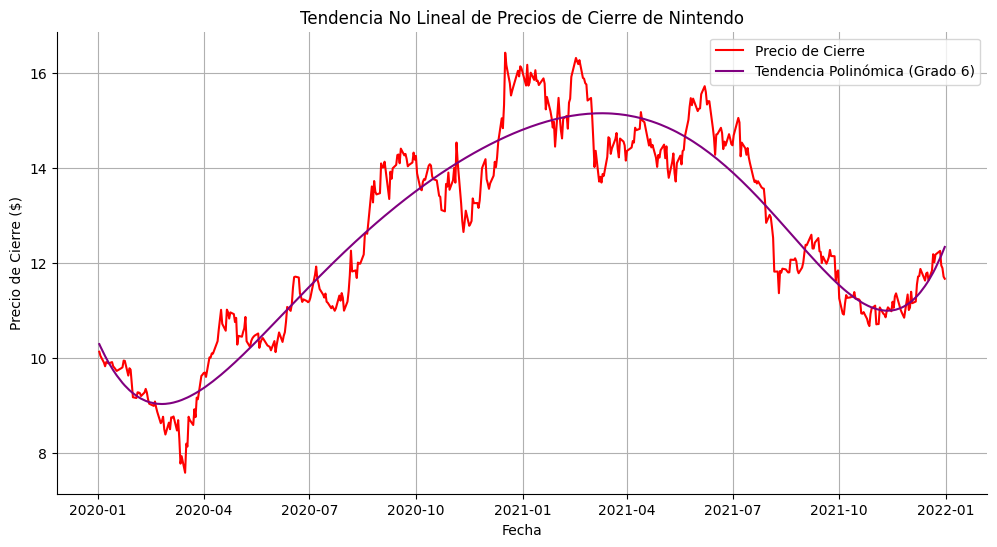

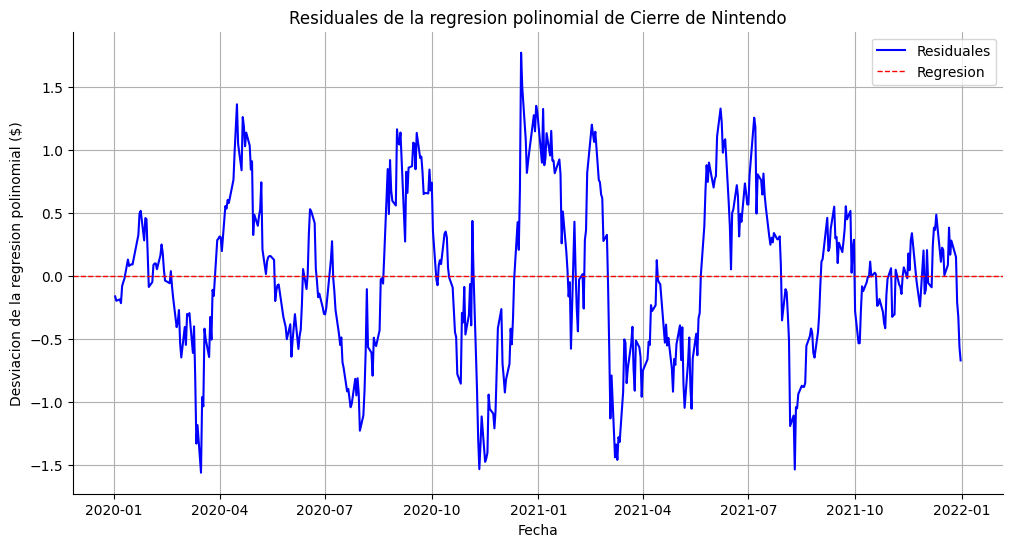

In [ ]:
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='red'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de Nintendo') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de Nintendo')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Descomposición de la Serie de Tiempo y su Gráfica**

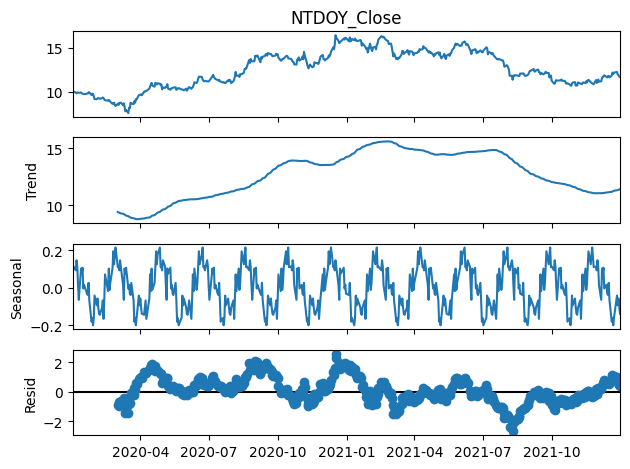

In [ ]:
# Descomponer la serie temporal
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(
    df['NTDOY_Close'],
    model='additive',
    period=40,
    extrapolate_trend=0,
    two_sided=False,
    )  # 252 días de negociación al año
fig = descomposicion.plot()
plt.show()

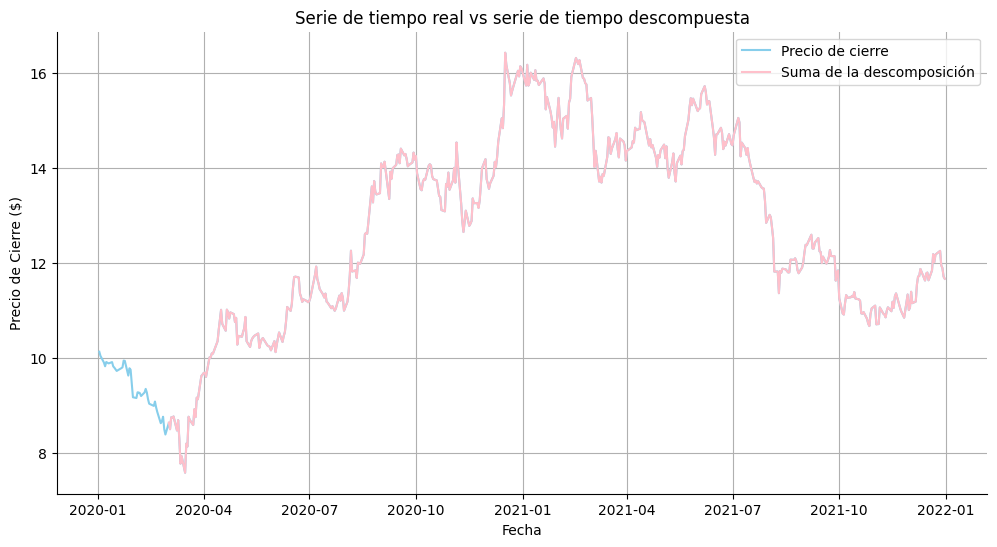

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['NTDOY_Close'], label='Precio de cierre', color='#87CEEB')
plt.plot(descomposicion.trend + descomposicion.seasonal + descomposicion.resid, label=f'Suma de la descomposición', color='pink')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

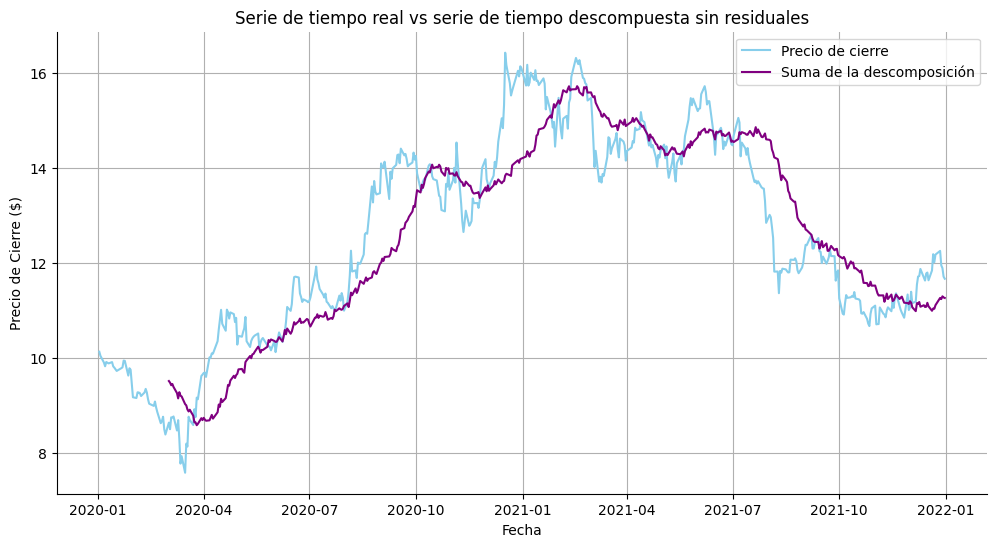

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['NTDOY_Close'], label='Precio de cierre', color='#87CEEB')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

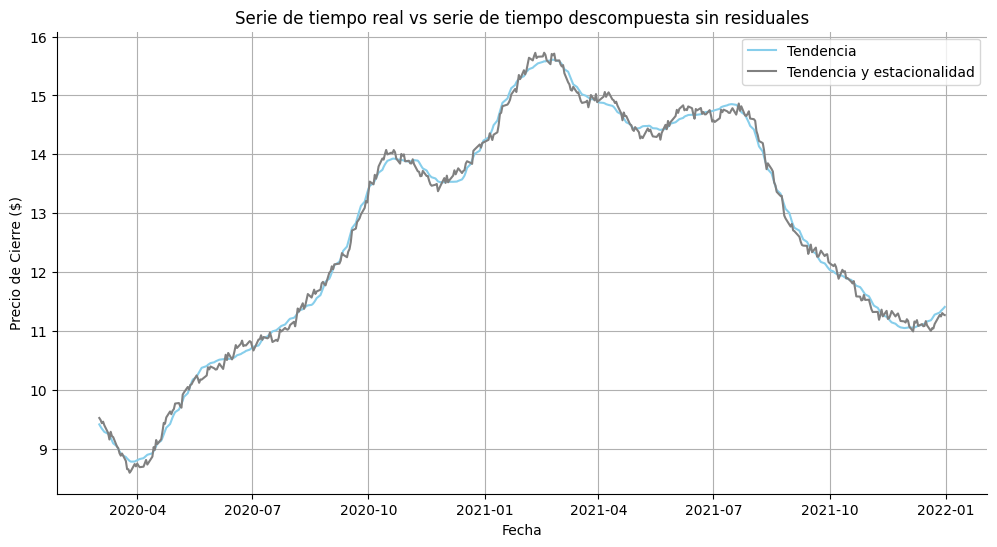

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(descomposicion.trend, label='Tendencia', color='#87CEEB')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Tendencia y estacionalidad', color='gray')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

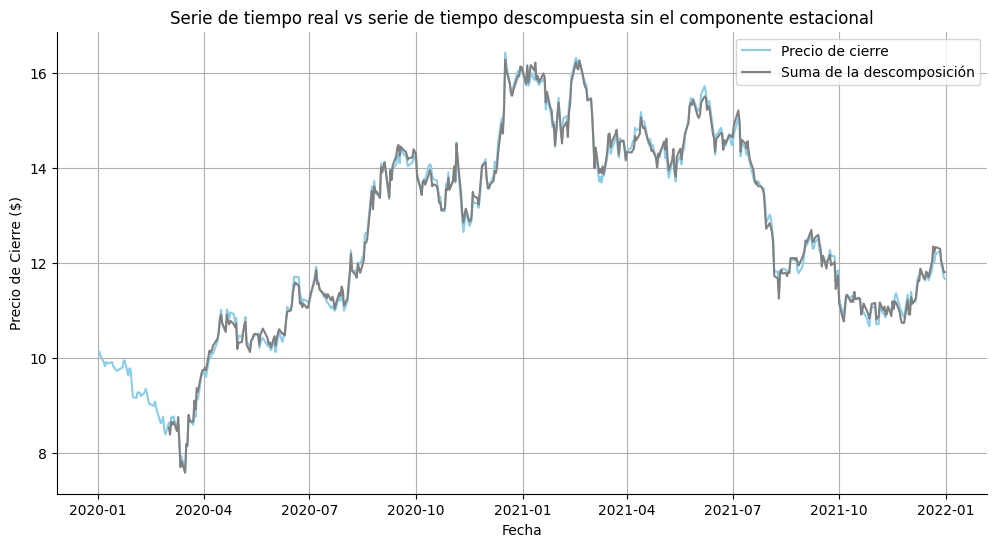

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['NTDOY_Close'], label='Precio de cierre', color='#87CEEB')
plt.plot(descomposicion.trend + descomposicion.resid, label=f'Suma de la descomposición', color='gray')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin el componente estacional')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Lo que se puede analizar de esto es que tiene una tendencia muy alcista y a la vez muy volatil, aunque su estacionalidad es más variada a comparación de la de mercado libre y el ruido es más pronunciado por lo que puede ser más díficil de predecir

 **Realiza una prueba de hipótesis para comprobar que se haya capturado correctamente la estacionalidad. Y realiza otra prueba de hipótesis para comprobar si la estacionalidad es significativa**

In [ ]:
# Prueba t pareada para el efecto significativo de la estacionalidad

#Hipótesis nula (H₀): Ambas series son iguales.
#Hipótesis alternativa (H₁): Ambas series son diferentes


nivel_de_significancia = 0.05
tendencia = descomposicion.trend
tendencia_estacionalidad = descomposicion.seasonal + descomposicion.trend

# Eliminar valores NaN de ambas series
tendencia.dropna(inplace=True)
tendencia_estacionalidad.dropna(inplace=True)

# Realizar la prueba t pareada
t_stat, p_valor = ttest_rel(tendencia, tendencia_estacionalidad)

print("Estadístico t:", t_stat)
print("Valor p:", p_valor)
print("\n")

# Interpretación de los resultados
if p_valor < nivel_de_significancia:
    print("El valor p es menor que 0.05, por lo tanto, rechazamos la hipótesis nula.")
    print("Conclusión: La estacionalidad tiene un efecto significativo en la serie de tiempo.")
else:
    print("El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.")
    print("Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.")

Estadístico t: 0.1820366551154779
Valor p: 0.8556334591201871


El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.
Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.


In [ ]:
# Prueba Wilcoxon pareada para el efecto significativo de la estacionalidad

#Hipótesis nula (H₀): Ambas series son iguales.
#Hipótesis alternativa (H₁): Ambas series son diferentes

tendencia = descomposicion.trend
tendencia_estacionalidad = descomposicion.seasonal + descomposicion.trend

# Eliminar valores NaN de ambas series
tendencia.dropna(inplace=True)
tendencia_estacionalidad.dropna(inplace=True)

# Realizar la prueba de Wilcoxon
w_stat, p_valor = wilcoxon(tendencia, tendencia_estacionalidad)

print("Estadístico de Wilcoxon:", w_stat)
print("Valor p:", p_valor)
print("\n")

# Interpretación de los resultados
if p_valor < 0.05:
    print("El valor p es menor que 0.05, por lo tanto, rechazamos la hipótesis nula.")
    print("Conclusión: La estacionalidad tiene un efecto significativo en la serie de tiempo.")
else:
    print("El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.")
    print("Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.")

Estadístico de Wilcoxon: 53923.0
Valor p: 0.9314164681962882


El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.
Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.


**Utilizando los componentes de la descomposición, realiza un gráfico que contenga la serie de tiempo real, la tendencia, la serie sin estacionalidad, y la serie sin ruido.**

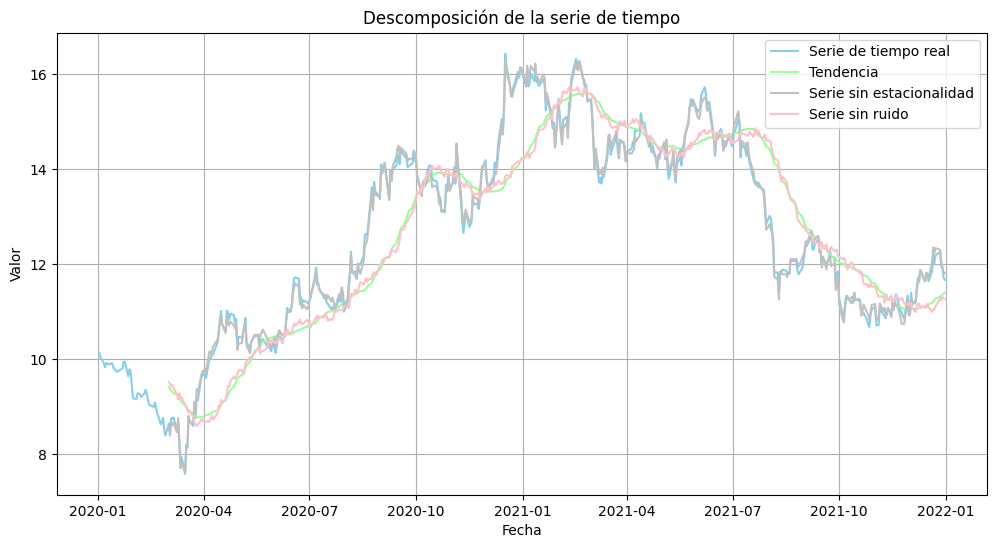

In [ ]:
# Define los datos para el gráfico
serie_real = df['NTDOY_Close']  # Serie de tiempo real
tendencia = descomposicion.trend  # Tendencia
sin_estacionalidad = descomposicion.trend + descomposicion.resid  # Serie sin estacionalidad
sin_ruido = descomposicion.trend + descomposicion.seasonal  # Serie sin ruido

# Crea el gráfico
plt.figure(figsize=(12, 6))
plt.plot(serie_real, label='Serie de tiempo real', color='#87CEEB')
plt.plot(tendencia, label='Tendencia', color='#98FF98')
plt.plot(sin_estacionalidad, label='Serie sin estacionalidad', color='#C0C0C0')
plt.plot(sin_ruido, label='Serie sin ruido', color='pink')

# Personaliza el gráfico
plt.title('Descomposición de la serie de tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)

# Muestra el gráfico
plt.show()

**Causalidad de Granger de Nintendo y Mercado Libre**

---



In [ ]:
# Hipótesis Nula (H₀): La serie X no causa en el sentido de Granger a la serie Y.

# Hipótesis Alternativa (H₁): La serie X causa en el sentido de Granger a la serie Y.

# Definir el número máximo de rezagos para la prueba
max_lags = 5

# Realizar la prueba de causalidad de Granger
# La función devuelve resultados para varios tests y cada rezago hasta el máximo definido
resultado = grangercausalitytests(df[['MELI_Close', 'NTDOY_Close']], max_lags, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8957  , p=0.1692  , df_denom=501, df_num=1
ssr based chi2 test:   chi2=1.9071  , p=0.1673  , df=1
likelihood ratio test: chi2=1.9035  , p=0.1677  , df=1
parameter F test:         F=1.8957  , p=0.1692  , df_denom=501, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7261  , p=0.1790  , df_denom=498, df_num=2
ssr based chi2 test:   chi2=3.4869  , p=0.1749  , df=2
likelihood ratio test: chi2=3.4749  , p=0.1760  , df=2
parameter F test:         F=1.7261  , p=0.1790  , df_denom=498, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5391  , p=0.2035  , df_denom=495, df_num=3
ssr based chi2 test:   chi2=4.6827  , p=0.1966  , df=3
likelihood ratio test: chi2=4.6610  , p=0.1984  , df=3
parameter F test:         F=1.5391  , p=0.2035  , df_denom=495, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5163  , p=0.1961  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


**Prueba Prophet de Mercado Libre y Nintendo**



---





INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qje2b_l/8wm2nldg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qje2b_l/_73ru6xq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70219', 'data', 'file=/tmp/tmp9qje2b_l/8wm2nldg.json', 'init=/tmp/tmp9qje2b_l/_73ru6xq.json', 'output', 'file=/tmp/tmp9qje2b_l/prophet_modelok_5m20u/prophet_model-20241122002008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:20:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:20:08 - cmdstanpy - INFO - Chain

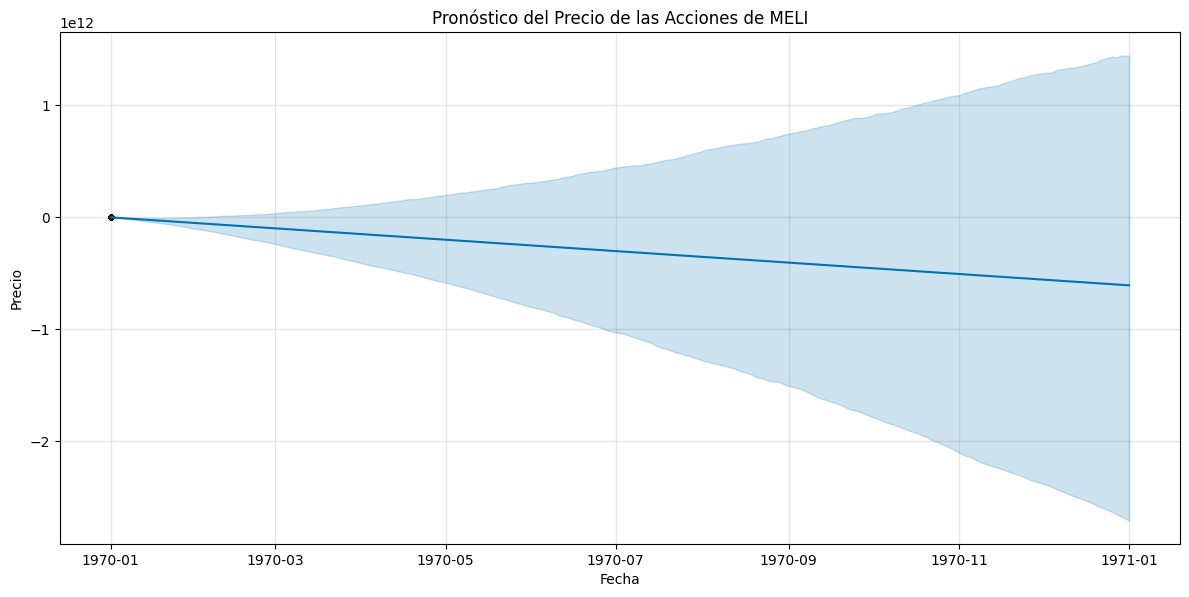

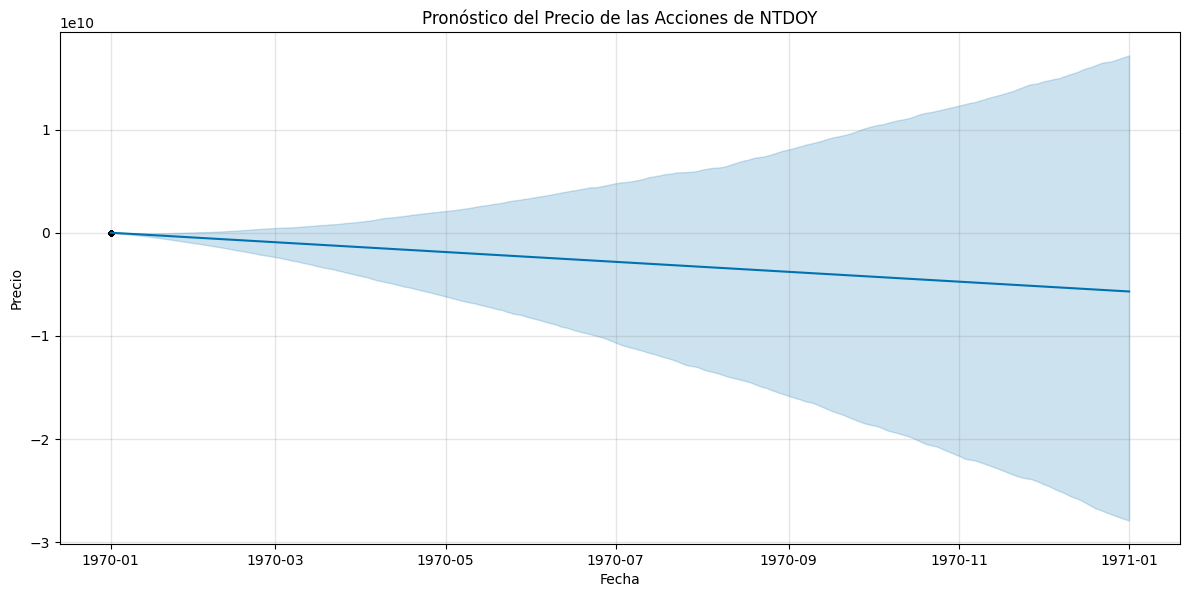

In [ ]:
def modelo_prophet(df, ticker):
  """
  Aplica el modelo Prophet a los datos del ticker dado.

  Args:
    df: DataFrame que contiene los datos de las acciones.
    ticker: El símbolo del ticker (por ejemplo, 'MELI', 'NTDOY').

  Returns:
    Un modelo Prophet ajustado a los datos y un DataFrame con el pronóstico.
  """

  # Prepara los datos para Prophet
  df_prophet = df[['Date', f'{ticker}_Close']].copy()
  df_prophet.rename(columns={'Date': 'ds', f'{ticker}_Close': 'y'}, inplace=True)

  # Crea y ajusta el modelo
  modelo = Prophet()
  modelo.fit(df_prophet)

  # Crea fechas futuras para el pronóstico
  futuro = modelo.make_future_dataframe(periods=365)  # Pronóstico para 1 año

  # Realiza las predicciones
  pronóstico = modelo.predict(futuro)

  #The return statement was indented with an extra space causing the IndentationError.
  #Removing the extra space before return aligns the indentation.
  return modelo, pronóstico

# Aplica el modelo a MELI
modelo_meli, pronóstico_meli = modelo_prophet(df, 'MELI')

# Aplica el modelo a NTDOY
modelo_ntdoy, pronóstico_ntdoy = modelo_prophet(df, 'NTDOY')

# Grafica los pronósticos
modelo_meli.plot(pronóstico_meli, xlabel='Fecha', ylabel='Precio', figsize=(12, 6))
plt.title('Pronóstico del Precio de las Acciones de MELI')
plt.show()

modelo_ntdoy.plot(pronóstico_ntdoy, xlabel='Fecha', ylabel='Precio', figsize=(12, 6))
plt.title('Pronóstico del Precio de las Acciones de NTDOY')
plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qje2b_l/0z8u6vke.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qje2b_l/ph7_hnh8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30360', 'data', 'file=/tmp/tmp9qje2b_l/0z8u6vke.json', 'init=/tmp/tmp9qje2b_l/ph7_hnh8.json', 'output', 'file=/tmp/tmp9qje2b_l/prophet_modelg5n_h69j/prophet_model-20241122002352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:23:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:23:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


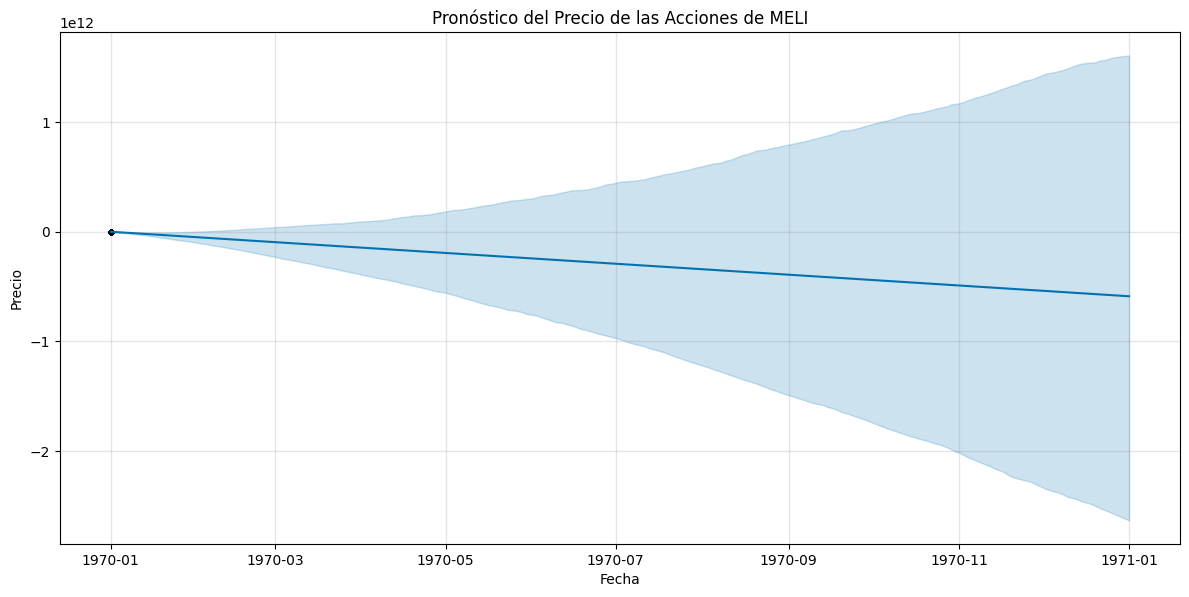

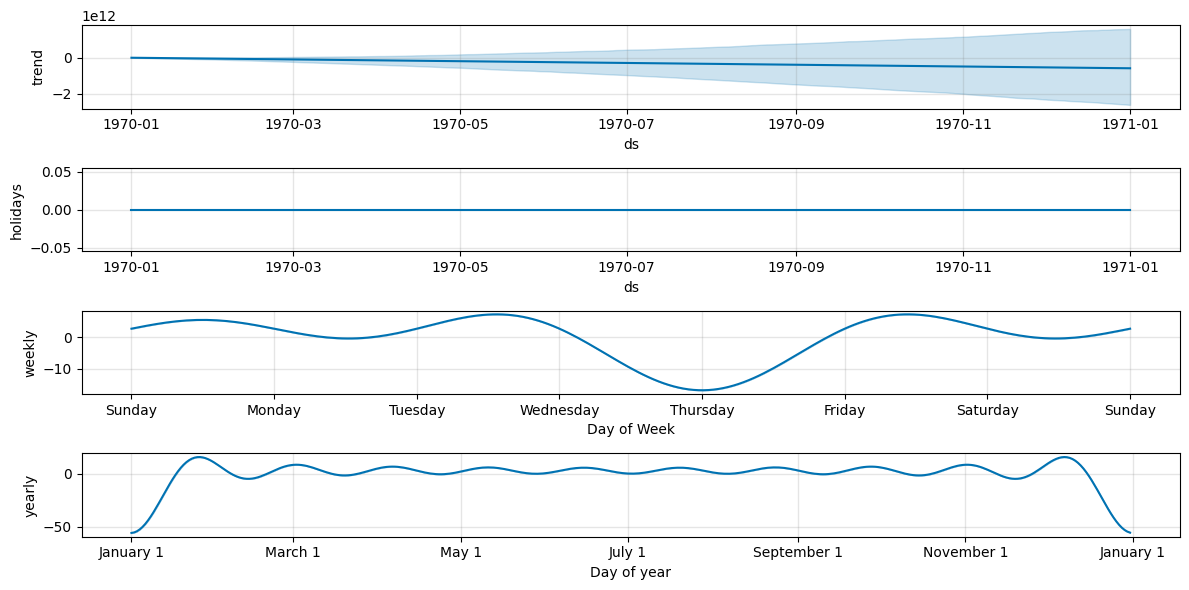

In [ ]:
df_prophet = df[['Date','MELI_Close']].reset_index(drop=True).copy()
df_prophet.rename(columns={'Date': 'ds', 'MELI_Close': 'y'}, inplace=True)

# Crear el modelo Prophet
# Considerar la estacionalidad semanal y anual
# Agregar días festivos de Estados Unidos
modelo = Prophet(
    weekly_seasonality=True,  # Habilitar estacionalidad semanal
    yearly_seasonality=True,   # Habilitar estacionalidad anual
    holidays=pd.DataFrame({     # Agregar días festivos
        'holiday': 'US Holiday',
        'ds': pd.to_datetime(['2020-01-01', '2020-01-20', '2020-02-17', '2020-05-25', '2020-07-03', '2020-09-07', '2020-11-26', '2020-12-25',
                               '2021-01-01', '2021-01-18', '2021-02-15', '2021-05-31', '2021-07-05', '2021-09-06', '2021-11-25', '2021-12-24']),
        'lower_window': 0,
        'upper_window': 1,
    })
)

# Ajustar el modelo a los datos
modelo.fit(df_prophet)

# Crear un DataFrame para el futuro
# Pronosticar para 365 días
futuro = modelo.make_future_dataframe(periods=365)

# Realizar el pronóstico
pronóstico = modelo.predict(futuro)

# Visualizar el pronóstico
modelo.plot(pronóstico, xlabel='Fecha', ylabel='Precio', figsize=(12, 6))
plt.title('Pronóstico del Precio de las Acciones de MELI')
plt.show()

# Visualizar los componentes del pronóstico (tendencia, estacionalidad)
modelo.plot_components(pronóstico, figsize=(12, 6))
plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qje2b_l/96vm6_8y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qje2b_l/f4qvykba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34365', 'data', 'file=/tmp/tmp9qje2b_l/96vm6_8y.json', 'init=/tmp/tmp9qje2b_l/f4qvykba.json', 'output', 'file=/tmp/tmp9qje2b_l/prophet_modelc4qc01qa/prophet_model-20241122002513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:25:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:25:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


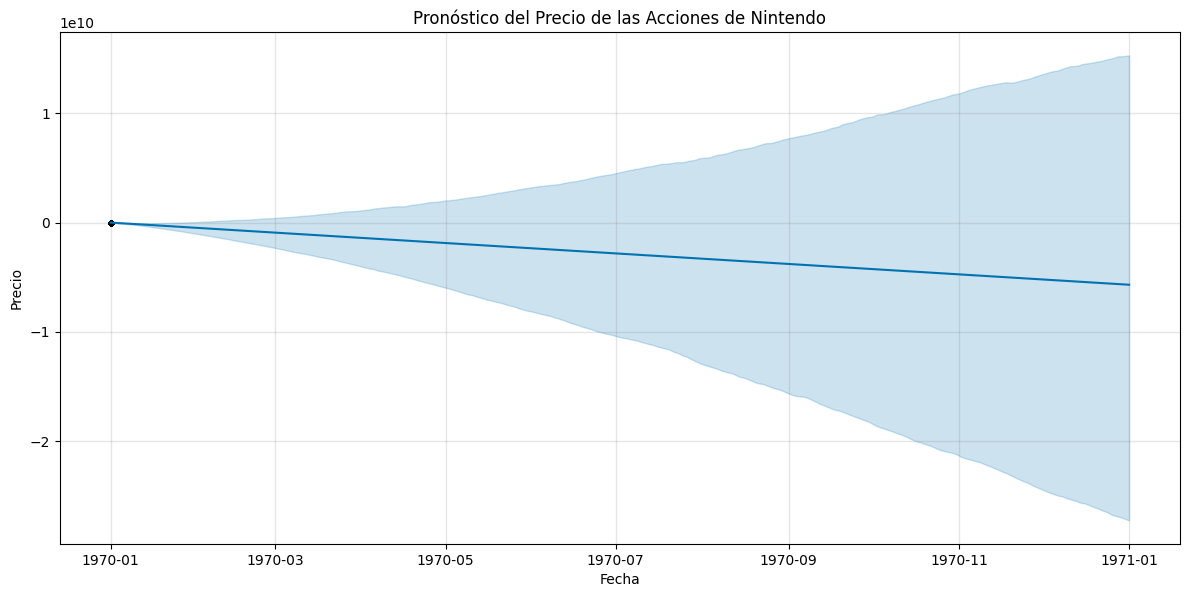

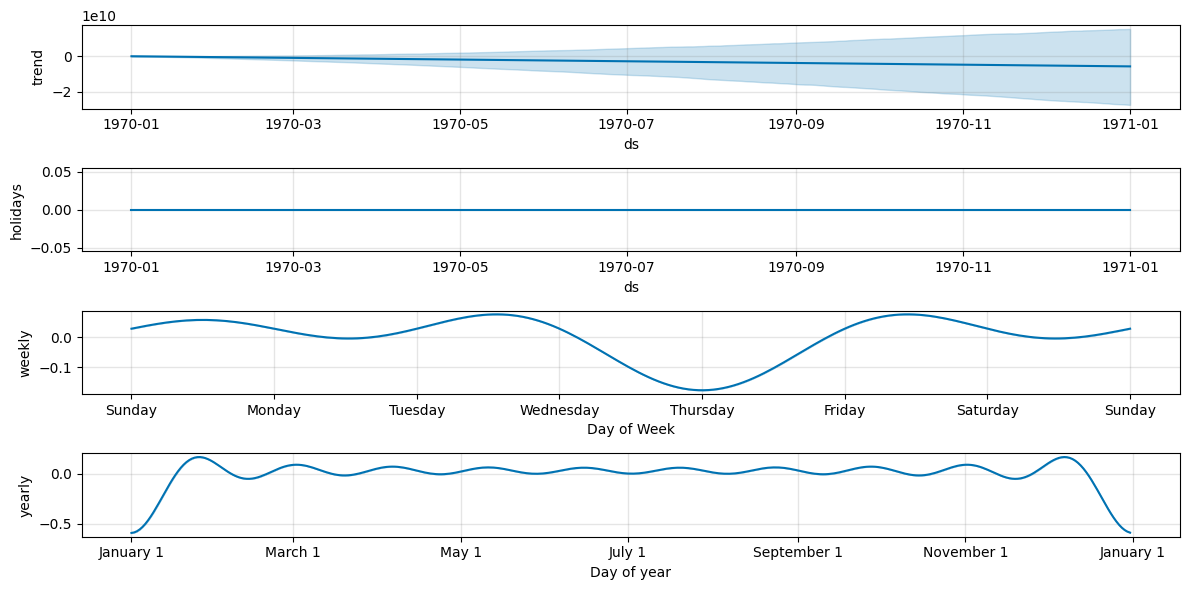

In [ ]:
df_prophet = df[['Date','NTDOY_Close']].reset_index(drop=True).copy()
df_prophet.rename(columns={'Date': 'ds', 'NTDOY_Close': 'y'}, inplace=True)

# Crear el modelo Prophet
# Considerar la estacionalidad semanal y anual
# Agregar días festivos de Estados Unidos
modelo = Prophet(
    weekly_seasonality=True,  # Habilitar estacionalidad semanal
    yearly_seasonality=True,   # Habilitar estacionalidad anual
    holidays=pd.DataFrame({     # Agregar días festivos
        'holiday': 'US Holiday',
        'ds': pd.to_datetime(['2020-01-01', '2020-01-20', '2020-02-17', '2020-05-25', '2020-07-03', '2020-09-07', '2020-11-26', '2020-12-25',
                               '2021-01-01', '2021-01-18', '2021-02-15', '2021-05-31', '2021-07-05', '2021-09-06', '2021-11-25', '2021-12-24']),
        'lower_window': 0,
        'upper_window': 1,
    })
)

# Ajustar el modelo a los datos
modelo.fit(df_prophet)

# Crear un DataFrame para el futuro
# Pronosticar para 365 días
futuro = modelo.make_future_dataframe(periods=365)

# Realizar el pronóstico
pronóstico = modelo.predict(futuro)

# Visualizar el pronóstico
modelo.plot(pronóstico, xlabel='Fecha', ylabel='Precio', figsize=(12, 6))
plt.title('Pronóstico del Precio de las Acciones de Nintendo')
plt.show()

# Visualizar los componentes del pronóstico (tendencia, estacionalidad)
modelo.plot_components(pronóstico, figsize=(12, 6))
plt.show()